# Setup

In [29]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime
import pandas as pd

from pandas import DataFrame,Series,read_table

General info

In [30]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 09/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig9b_'

In [31]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

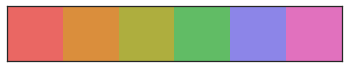

In [32]:
colors_PSG = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors_PSG)

# colorpalette from iWantHue

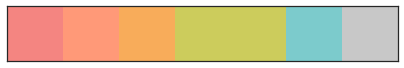

In [33]:
# video scores
colors_video = sns.color_palette(np.array([[244,133,129],
                                           [255,153,120],
                                            [248,172,90],
                                            [204,204,92],
                                            [204,204,92],
                                            [124, 203, 204],
                                            [200, 200, 200]])
                                            /(255))

sns.palplot(colors_video)

## for this notebook: set stages and colors to correspond to video scores

In [34]:
colors = colors_video
stages = stagesVideo

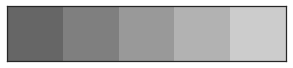

In [35]:
colors_birds = [np.repeat(.4, 3),
                np.repeat(.5, 3),
                np.repeat(.6, 3),
                np.repeat(.7, 3),
                np.repeat(.8, 3)]

sns.palplot(colors_birds)


Plot-specific info

In [36]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")
axis_label_fontsize = 24

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [37]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Read in files

In [38]:
birds = ['1', '2', '3', '4', '5', '2LL', '3LL', '4LL']

### Load formatted scores

In [39]:
AllScores = {}
for b in birds:
    bird_name = 'Bird ' + b
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[b] = data

### Convert video labels to numbers

In [40]:
for b in birds:

    #b_num = int(b_name[5]) - 1
    Scores = AllScores[b]

    Label_num = -1 * np.ones_like(Scores['Video Label'])
    for st in range(len(stagesVideo)):
        stage_inds = [x for x in range(len(Scores['Video Label'])) if stagesVideo[st] in Scores['Video Label'].iloc[x]]
        Label_num[stage_inds] = st

    # Preening/singing labels
    stage_inds = [x for x in range(len(Scores['Video Label']))
                  if ('p' in Scores['Video Label'].iloc[x])|('si' in Scores['Video Label'].iloc[x])]
    Label_num[stage_inds] = 0
    
    # Unihem labels
    stage_inds = [x for x in range(len(Scores['Video Label'])) 
                  if ('r' in Scores['Video Label'].iloc[x])|
                     ('l' in Scores['Video Label'].iloc[x])] # Consolidate both L and R unihem sleep
    Label_num[stage_inds] = 4

    # Save to dataframe
    AllScores[b]['Video Label (#)'] = Label_num

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [41]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b in birds:    
    b_num = int(b[0]) - 1
    
    Scores = AllScores[b]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [42]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

In [43]:
figsize = (6,6)
axis_label_fontsize = 24
smaller_label_fontsize = 20

# Line formatting
linewidth = 5
linealpha = .7
marker = 'o'
markersize = 10
err_capsize = 3
err_capthick = 3
elinewidth = 3

# Bar formatting
bar_linewidth = 4

# Entire 24 hrs

In [44]:
stageProportions_all = {}

for b in birds:

    stageProportions = DataFrame([], columns=range(len(stages)))

    #b_name = 'Bird ' + str(b) 
    Scores = AllScores[b]

    bn_scores = Scores
    bn_stage_frequencies = bn_scores['Video Label (#)'].value_counts(normalize=True,sort=False)
                
    stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)
    
    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Add to dictionary
    stageProportions_all[b] = stageProportions
    

In [45]:
stageProportions_all

{'1':           0         1         2    3         4         5         6
 0  0.257395  0.113925  0.142513  0.0  0.013762  0.448287  0.024119,
 '2':          0         1         2    3         4         5         6
 0  0.24396  0.235779  0.055977  0.0  0.020957  0.366776  0.076551,
 '3':           0         1         2    3         4         5        6
 0  0.096727  0.121068  0.225434  0.0  0.058793  0.487118  0.01086,
 '4':          0         1         2    3         4         5         6
 0  0.20769  0.064977  0.142399  0.0  0.003242  0.529996  0.051696,
 '5':          0         1         2    3         4         5         6        -1
 0  0.15446  0.128002  0.269111  0.0  0.039007  0.397393  0.011991  0.000035,
 '2LL':           0         1         2    3    4         5         6
 0  0.607128  0.095248  0.126442  0.0  0.0  0.145547  0.025636,
 '3LL':           0         1         2    3    4         5    6
 0  0.189528  0.138111  0.413009  0.0  0.0  0.259351  0.0,
 '4LL':           0 

### Organize proportions by stage

In [46]:
stageProportions_by_stage = {}

stage_labels = stageProportions_all[birds[0]].columns.values

for st in stage_labels:
    stageProportions_stage = DataFrame([])
    
    for b in birds:
        stageProportions_bird = stageProportions_all[b]
        stageProportions_stage[b] = stageProportions_bird[st]
        
    stageProportions_by_stage[st] = stageProportions_stage

## Bar graphs: Plot each stage

### FIGURE 7B

In [72]:
birds_LD_only = ['1', '5']
birds_LD = ['2', '3', '4']
birds_LL = ['2LL', '3LL', '4LL']

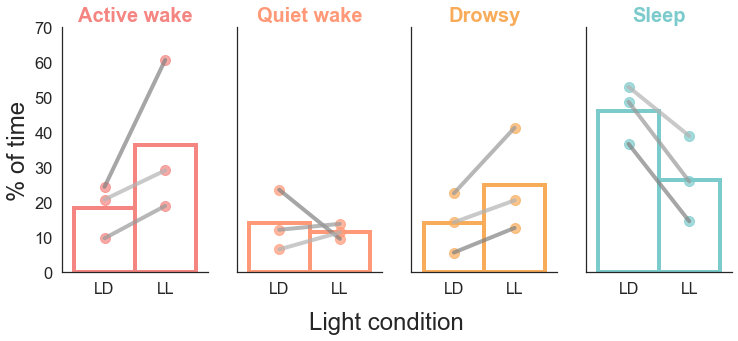

In [48]:
stages_to_plot = [0,1,2,5]
stage_names = ['Active wake', 'Quiet wake', 'Drowsy', '', 'Uni', 'Sleep']

plt.figure(figsize=(12,4.5))

for i, st in enumerate(stages_to_plot):
   # stage_color = colors[i]
    plt.subplot(1, len(stages_to_plot), i+1)

    # Lines color coded by bird
    for b in birds_LD:
        #b_name = 'Bird ' + str(b+1)
        b_num = int(b[0]) - 1
        tmp_LD = stageProportions_by_stage[st][b]*100
        tmp_LL = stageProportions_by_stage[st][b + 'LL']*100
        plt.plot([0,1], [tmp_LD, tmp_LL], color=colors_birds[b_num], alpha=linealpha, lw=4)
        
    # Scatter plot of each bird
    plt.scatter(np.repeat(0, len(birds_LD)), stageProportions_by_stage[st][birds_LD].values*100,
                10*markersize, color=colors[st], alpha=linealpha)
    #plt.scatter(np.repeat(-.25, len(birds_LD_only)), stageProportions_by_stage[st][birds_LD_only].values*100, color=colors[st], alpha=.7)
    plt.scatter(np.repeat(1, len(birds_LL)), stageProportions_by_stage[st][birds_LL].values*100,
                10*markersize, color=colors[st], alpha=linealpha)

    # Bar graph of mean
    LD_mean = np.nanmean(stageProportions_by_stage[st][birds_LD].values)*100
    LL_mean = np.nanmean(stageProportions_by_stage[st][birds_LL].values)*100

    plt.bar([0,1],[LD_mean, LL_mean], width=1, color='none', edgecolor=colors[st], linewidth=4)


    plt.xlim(-.7, 1.7)
    plt.xticks([0,1], ['LD', 'LL'],fontsize=16)
    plt.title(stage_names[st], color=colors[st], fontsize=20, fontweight='bold')

    if i==0:
        plt.ylabel('% of time', fontsize=axis_label_fontsize)  # y label only on leftmost plot
    else:
        plt.yticks([])

    plt.ylim(0,70)
    sns.despine()

fig = plt.gcf()
fig.text(0.5, -.05, 'Light condition', ha='center', fontsize=axis_label_fontsize)


if savePlots:
        plt.savefig(saveAsPath + saveAsName + "bargraph.pdf")


# STATS

## save to csv

In [109]:
stageProportions[np.arange(7)]

,0,1,2,3,4,5,6
0,0.15446,0.128002,0.269111,0.0,0.039007,0.397393,0.011991


In [101]:
stageProportions[0:len(stages)].values

array([[1.54460208e-01, 1.28002231e-01, 2.69111444e-01, 0.00000000e+00,
        3.90072158e-02, 3.97392547e-01, 1.19914944e-02, 3.48589954e-05]])

In [113]:
# note: all unihem sleep has been combined into one column
# - so column 'l' will be empty, and 'g' will contain all unihem data not just the right side

if saveData:
    stageProp_all = pd.DataFrame([], index=stages)
    for bird in np.sort(np.append(birds_LD, birds_LD_only)):        
        stageProportions = stageProportions_all[bird]
        stageProp_all['Bird ' + bird] = stageProportions[np.arange(len(stages))].values[0]
    stageProp_all.to_csv(saveAsPath + saveAsName + 'stage_proportions_LD.csv')
    
    stageProp_all = pd.DataFrame([], index=stages)
    for bird in birds_LL:        
        stageProportions = stageProportions_all[bird]
        stageProp_all['Bird ' + bird] = stageProportions[np.arange(len(stages))].values[0]
    stageProp_all.to_csv(saveAsPath + saveAsName + 'stage_proportions_LL.csv')
    

## Stats: active wake

In [49]:
data = stageProportions_by_stage[0]
dataLD = data[birds_LD]
dataLL = data[birds_LL]
dataLD

,2,3,4
0,0.24396,0.096727,0.20769


In [50]:
dataLL

,2LL,3LL,4LL
0,0.607128,0.189528,0.290974


In [51]:
print('mean LD:', np.round(dataLD.mean(axis=1).values[0]*100, decimals=2), '%')
print('\t +/-', np.round((dataLD.std(axis=1).values[0]*100)/np.sqrt(len(birds_LD)), decimals=2), '%')

print('mean LL:', np.round(dataLL.mean(axis=1).values[0]*100, decimals=2), '%')
print('\t +/-', np.round((dataLL.std(axis=1).values[0]*100)/np.sqrt(len(birds_LL)), decimals=2), '%')


mean LD: 18.28 %
	 +/- 4.43 %
mean LL: 36.25 %
	 +/- 12.57 %


In [52]:
dataLD.values

array([[0.24396018, 0.09672708, 0.20768989]])

In [53]:
stat.ttest_rel(dataLD.values[0], dataLL.values[0], axis=0)

Ttest_relResult(statistic=-1.9591524521528245, pvalue=0.18917742032202786)

## Stats: quiet wake

In [54]:
data = stageProportions_by_stage[1]
dataLD = data[birds_LD]
dataLL = data[birds_LL]
dataLD

,2,3,4
0,0.235779,0.121068,0.064977


In [55]:
dataLL

,2LL,3LL,4LL
0,0.095248,0.138111,0.113666


In [56]:
print('mean LD:', np.round(dataLD.mean(axis=1).values[0]*100, decimals=2), '%')
print('\t +/-', np.round((dataLD.std(axis=1).values[0]*100)/np.sqrt(len(birds_LD)), decimals=2), '%')

print('mean LL:', np.round(dataLL.mean(axis=1).values[0]*100, decimals=2), '%')
print('\t +/-', np.round((dataLL.std(axis=1).values[0]*100)/np.sqrt(len(birds_LL)), decimals=2), '%')


mean LD: 14.06 %
	 +/- 5.03 %
mean LL: 11.57 %
	 +/- 1.24 %


In [57]:
dataLD.values

array([[0.23577943, 0.121068  , 0.06497717]])

In [58]:
stat.ttest_rel(dataLD.values[0], dataLL.values[0])

Ttest_relResult(statistic=0.42608784222800633, pvalue=0.711519493240347)

## Stats: drowsy

In [59]:
data = stageProportions_by_stage[2]
dataLD = data[birds_LD]
dataLL = data[birds_LL]
dataLD

,2,3,4
0,0.055977,0.225434,0.142399


In [60]:
dataLL

,2LL,3LL,4LL
0,0.126442,0.413009,0.205246


In [61]:
print('mean LD:', np.round(dataLD.mean(axis=1).values[0]*100, decimals=2), '%')
print('\t +/-', np.round((dataLD.std(axis=1).values[0]*100)/np.sqrt(len(birds_LD)), decimals=2), '%')

print('mean LL:', np.round(dataLL.mean(axis=1).values[0]*100, decimals=2), '%')
print('\t +/-', np.round((dataLL.std(axis=1).values[0]*100)/np.sqrt(len(birds_LL)), decimals=2), '%')


mean LD: 14.13 %
	 +/- 4.89 %
mean LL: 24.82 %
	 +/- 8.55 %


In [62]:
dataLD.values

array([[0.05597716, 0.22543439, 0.142399  ]])

In [63]:
stat.ttest_rel(dataLD.values[0], dataLL.values[0])

Ttest_relResult(statistic=-2.649785809353938, pvalue=0.11778457547805099)

## Stats: sleep

In [64]:
data = stageProportions_by_stage[5]
dataLD = data[birds_LD]
dataLL = data[birds_LL]
dataLD

,2,3,4
0,0.366776,0.487118,0.529996


In [65]:
dataLL

,2LL,3LL,4LL
0,0.145547,0.259351,0.389661


In [66]:
print('mean LD:', np.round(dataLD.mean(axis=1).values[0]*100, decimals=2), '%')
print('\t +/-', np.round((dataLD.std(axis=1).values[0]*100)/np.sqrt(len(birds_LD)), decimals=2), '%')

print('mean LL:', np.round(dataLL.mean(axis=1).values[0]*100, decimals=2), '%')
print('\t +/-', np.round((dataLL.std(axis=1).values[0]*100)/np.sqrt(len(birds_LL)), decimals=2), '%')


mean LD: 46.13 %
	 +/- 4.89 %
mean LL: 26.49 %
	 +/- 7.05 %


In [67]:
dataLD.values

array([[0.36677574, 0.48711803, 0.52999617]])

In [68]:
stat.ttest_rel(dataLD.values[0], dataLL.values[0])

Ttest_relResult(statistic=6.986471908134235, pvalue=0.01987843532737398)